## Bibliothèques

In [198]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import random as rd
from tqdm import tqdm

## Données

In [199]:
def traitement(data_init):
    n, m = np.shape(data_init)
    result = np.zeros((0,m))
    for i in range(n):
        string = "?"
        if string not in data_init[i,:]:
            result = np.vstack((result, data_init[i,:]))
    result = np.array(result, dtype = float)
    return result

In [200]:
data_init = pd.read_csv("mammographic_masses.data",header=None)
data_init = np.array(data_init)
clean_data = traitement(data_init)

### Signification de chaque caracteristique, dans l'ordre ###
# BI RADS
# Age de la patiente
# Forme de la masse, non ordinal
# Frontière de la masse, non ordinal 
# Densité, ordinal
# Bénigne (0) ou maline (1)

## Implémentation

In [201]:
# Fonctions pour le calcul de parametres de l'algorithme EM

def sigmoid(z):
    # Calcul de la fonction sigmoide pour la regression logistique
    return 1 / (1 + np.exp(-z))

def p_i(w, x):
    # w est un vecteur, x est une matrice
    w = w.reshape(-1)
    return sigmoid(x.dot(w))

def a_i(alpha, annotations):
    # Renvoie le vecteur des a_i
    result = alpha**annotations * ((1-alpha)**(1 - annotations))
    result = np.prod(result, axis=1)
    return result

def b_i(beta, annotations):
    # Renvoie le vecteur des b_i
    result = beta**(1 - annotations) * ((1-beta)**annotations)
    result = np.prod(result, axis=1)
    return result

def alpha_j(mu, annotations):
    # Renvoie le vecteur des alpha_j
    return mu.dot(annotations) / np.sum(mu)

def beta_j(mu, annotations):
    # Renvoie le vecteur des beta_j
    return (1 - mu).dot(1 - annotations) / np.sum(1 - mu)

def mu_i(data, w, alpha, beta, annotations):
    # Renvoie le vecteur des mu_i
    a = a_i(alpha, annotations)
    b = b_i(beta, annotations)
    p = p_i(w, data)
    numerateur = a*p
    denominateur = numerateur + b*(1-p)
    result = np.where(denominateur > 0, numerateur/denominateur, 0.5)
    return result

In [202]:
def norme(w):
    # Renvoie la norme du vecteur w
    return(np.sqrt(w.dot(w)))

def grad(data, mu, w):
    p = p_i(w, data)
    return (mu - p).dot(data)

def hess(data, w):
    p = p_i(w, data)
    diag = np.diag(p * (1 - p))
    return - (data.T).dot(diag.dot(data))

def gradient_descent(grad_f, hess_f, data, mu, winit, max_iter = 1000, stop = 1e-4):
    # Descente de gradient pour estimer la valeur optimale de w
    pas = 1
    w = winit
    w_moins = 0
    i = 1
    while (i<max_iter) & (norme(w-w_moins)>stop):
        w_moins = w
        w = w_moins - pas * np.linalg.inv(hess_f(data,w)).dot(grad_f(data,mu,w))
        pas = 1/np.sqrt(i)
        i += 1
    return w

In [203]:
def EM_algorithm(data, annotations, winit, nb_iter = 50):
    # Calcule l'argument maximisant la vraisemblance
    mu = np.mean(annotations, axis = 1) # initilisation de mu
    w = winit # initialisation de w
    
    for ite in tqdm(range(nb_iter)):
        # M step
        alpha = alpha_j(mu, annotations) # met à jour alpha
        beta = beta_j(mu, annotations) # met à jour beta
        w = gradient_descent(grad, hess, data, mu, w) # met à jour w
        # E step
        mu = mu_i(data, w, alpha, beta, annotations) # met à jour mu
        
    return w, alpha, beta, mu

# Simulation d'avis

In [204]:
def doc_decide(alpha, beta, label):
    if label == 0:
        return int(rd.random() > beta)
    else:
        return int(rd.random() < alpha)
    
def choix_medecin(alphas, betas, labels):
    # Simulation du choix de chaque radiologue
    nb_medecin = len(alphas)
    nb_patient = np.shape(labels)[0]
    data = np.array([[doc_decide(alphas[j], betas[j], labels[i]) for j in range(nb_medecin) ] for i in range(nb_patient)])
    return data

# Test

In [205]:
# Spécificite et sensibilite des annotateurs 
alphas = np.array([0.9, 0.8, 0.57, 0.6, 0.55])
betas = np.array([0.95, 0.85, 0.62, 0.65, 0.58])

# Données pour l'apprentissage
data = clean_data[:,0:4]
labels = np.array(clean_data[:,5])
annotations = choix_medecin(alphas, betas, labels)

# Valeur initiale
data_line_nb, data_col_nb = np.shape(data)
winit = 0.01 * np.random.rand(data_col_nb)

# Optimisation
w, alpha, beta, mu = EM_algorithm(data=data, annotations=annotations, winit=winit, nb_iter = 70)

# Affichage des résultats
print('Alpha')
print("d'origine : ", alphas)
print("calculé   : ", alpha)
print('Max des erreurs sur les alpha_j : ', np.max(abs(alphas-alpha)))
print('\n')

print('Beta : ')
print("d'origine : ", betas)
print("calculé   : ", beta)
print('Max des erreurs sur les beta_j : ', np.max(abs(betas-beta)))
print('\n')

print('Erreur label : ', np.sum(labels), np.sum(mu))

100%|█████████████████████████████████████████| 70/70 [00:00<00:00, 194.79it/s]


Alpha
d'origine :  [ 0.9   0.8   0.57  0.6   0.55]
calculé   :  [ 0.9026308   0.81548304  0.52189021  0.62189683  0.56498187]
Max des erreurs sur les alpha_j :  0.0481097887822


Beta : 
d'origine :  [ 0.95  0.85  0.62  0.65  0.58]
calculé   :  [ 0.97530335  0.87639311  0.61501935  0.68808601  0.58841975]
Max des erreurs sur les beta_j :  0.0380860067841


Erreur label :  403.0 419.737386366


Ci-dessous, on apprend sur la base de données pour ensuite estimer le cas de chaque patient. Pour cela, on calcule la probabilité suivant l'hypothèse de régression logistique. On fait ensuite appel à un seuil $\gamma$ pour décider de quel côté se ranger.

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 1544.58it/s]


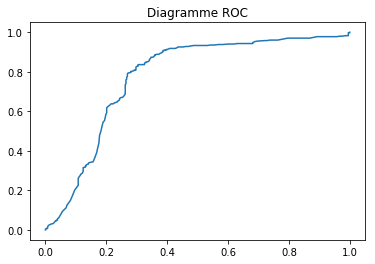

In [206]:
# Spécificite et sensibilite des annotateurs 
alphas = np.array([0.9, 0.8, 0.57, 0.6, 0.55])
betas = np.array([0.95, 0.85, 0.62, 0.65, 0.58])

# Données pour l'apprentissage
data = clean_data[:,0:4]
labels = np.array(clean_data[:,5])
annotations = choix_medecin(alphas, betas, labels)

# Valeur initiale
data_line_nb, data_col_nb = np.shape(data)
winit = 0.01 * np.random.rand(data_col_nb)

# Optimisation
w, alpha, beta, mu = EM_algorithm(data=data, annotations=annotations, winit=winit, nb_iter = 70)

# Utilisation de seuils pour arbitrer le rapport vrai-positif/vrai-negatif
gammas = np.linspace(0.4, 0.8, 500)
reglog_prob = sigmoid(p_i(w, data))

# Tracé du diagramme ROC
labels_0_index = np.array([i for i in range(len(labels)) if labels[i] == 0])
labels_0_nb = len(labels_0_index)
labels_1_index = np.array([i for i in range(len(labels)) if labels[i] == 1])
labels_1_nb = len(labels_1_index)
TP_list = []
FN_list = []
for gamma in tqdm(gammas):
    choice = np.where(reglog_prob > gamma, 1, 0)
    TP = np.sum([labels[i] == choice[i] for i in labels_1_index]) / labels_1_nb
    FN = 1 - np.sum([labels[i] == choice[i] for i in labels_0_index]) / labels_0_nb
    TP_list.append(TP)
    FN_list.append(FN)
plt.plot(FN_list, TP_list)
plt.title("Diagramme ROC")